### This file is used to predict all ratings in user_item matrix and find top k recommendations for any user

#### Read user and item csv files

In [1]:
import pandas as pd
import gzip
from PIL import Image
from PIL import ImageOps
import urllib.request as urllib
import urllib.error as err

import io
import numpy as np

def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

In [2]:
df.head(10)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5.0,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5.0,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5.0,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5.0,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5.0,Grammy's Angels Love it,1394841600,"03 15, 2014"
5,A27UF1MSF3DB2,0000031887,"C-Lo ""Cynthia""","[0, 0]",I received this today and I'm not a fan of it ...,4.0,It's ok,1396224000,"03 31, 2014"
6,A16GFPNVF4Y816,0000031887,design maven,"[0, 0]",Bought this as a backup to the regular ballet ...,5.0,Great for dress-up and for ballet practice,1399075200,"05 3, 2014"
7,A2M2APVYIB2U6K,0000031887,Jamie P.,"[0, 0]",Great tutu for a great price. It isn't a &#34;...,5.0,Great value,1356220800,"12 23, 2012"
8,A1NJ71X3YPQNQ9,0000031887,JBerger,"[0, 0]","My daughter liked this, and it with her costum...",4.0,Good,1384041600,"11 10, 2013"
9,A3EERSWHAI6SO,0000031887,"Jeffrey Hollingshead ""Jillian hollingshead""","[7, 8]",For what I paid for two tutus is unbeatable an...,5.0,WOW !! ..is all I have to say!,1349568000,"10 7, 2012"


In [3]:
user_item_data = df[['reviewerID','asin','overall','reviewTime','unixReviewTime']]

In [4]:
user_item_data.size

1393385

In [5]:
user_item_data.columns = ["User_Id", "Item_Id", "Rating", "TimeStamp","TimeStamp2"]

In [6]:
user_item_data.head()

,User_Id,Item_Id,Rating,TimeStamp,TimeStamp2
0,A1KLRMWW2FWPL4,0000031887,5.0,"02 12, 2011",1297468800
1,A2G5TCU2WDFZ65,0000031887,5.0,"01 19, 2013",1358553600
2,A1RLQXYNCMWRWN,0000031887,5.0,"01 4, 2013",1357257600
3,A8U3FAMSJVHS5,0000031887,5.0,"04 27, 2014",1398556800
4,A3GEOILWLK86XM,0000031887,5.0,"03 15, 2014",1394841600


#### No. of Unique Users

In [7]:
len(user_item_data["User_Id"].unique())

39387

#### No. of Unique Items

In [8]:
len(user_item_data["Item_Id"].unique())

23033

#### Subset3

In [9]:
top_item = user_item_data.groupby(['Item_Id'])['Rating'].count().reset_index().sort_values(['Rating'], ascending=False).head(1000) 
top_item = top_item["Item_Id"].tolist()

In [10]:
subset_user_item_data = user_item_data.loc[(user_item_data["Item_Id"].isin(top_item))]
len(subset_user_item_data["Item_Id"].unique())

1000

In [11]:
top_user = subset_user_item_data.groupby(['User_Id'])['Rating'].count().reset_index().sort_values(['Rating'], ascending=False).head(5000)
top_user = top_user["User_Id"].tolist()

In [12]:
subset_user_item_data = subset_user_item_data.loc[(user_item_data["User_Id"].isin(top_user))]
len(subset_user_item_data["User_Id"].unique())

5000

In [13]:
len(subset_user_item_data["Item_Id"].unique())

1000

#### Create test set

In [14]:
import random
def create_testdataset(dataset,k):
    test_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
    for i in range(0,k):
        index = random.choice(dataset.index.values.tolist())
        user = dataset.loc[index,'User_Id']
        item = dataset.loc[index,'Item_Id']
        rating = dataset.loc[index,'Rating']
        df = pd.DataFrame([[user,item,rating]],columns=["User_Id","Item_Id","Rating"])
        test_df = test_df.append(df)
    return test_df

In [15]:
test_df = create_testdataset(subset_user_item_data,5)
test_df = test_df.reset_index()
del test_df['index']
test_df.head(5)

,User_Id,Item_Id,Rating
0,A3B9AKWNSKHFLW,B0001ZNZJM,5.0
1,A328HGLW1QWLJV,B004Y53ETQ,5.0
2,AL5GX3Y4LRHK1,B002RADHJC,5.0
3,A13LKNC6P4HFZO,B0001ZNZJM,3.0
4,A3OZR1HAPF767K,B0066C71G2,5.0


#### Create user_item matrix and check sparsity

In [16]:
import scipy.sparse
from scipy.sparse import csr_matrix
import sklearn

In [17]:
#Create user-item matrix from train set dataframe
subset_user_item_data = subset_user_item_data[["User_Id","Item_Id","Rating"]]
user_item_pivot = subset_user_item_data.pivot(index="User_Id",columns="Item_Id", values="Rating")
userId = user_item_pivot.index
itemId = user_item_pivot.columns

In [18]:
#Remove the ratings of rows in test set from train set
for i in range(0,test_df.shape[0]):
    user_item_pivot.loc[test_df.User_Id[i]][test_df.Item_Id[i]] = np.nan

In [19]:
#Create matrix filled with zeros and not filled with zeros
user_item_matrix = csr_matrix(user_item_pivot.values)
user_item_pivot_filled_zeros = user_item_pivot.fillna(0)
user_item_matrix_filled_zeros = csr_matrix(user_item_pivot_filled_zeros.values)

In [20]:
#Calculate sparsity of user_item matrix
missing = pd.DataFrame(np.isnan(user_item_pivot).sum()/np.prod(user_item_pivot.shape))
missing = missing.reset_index()
missing.columns = ["Item_Id", "percent_missing"]
missing.percent_missing.sum()

0.995678

### Baseline Model

#### Matrix Factorization

In [21]:
#calculate mean of ratings for each user
user_item_pivot_base = user_item_pivot.copy(deep=True)

In [22]:
#calculate mean of ratings for each user
user_item_pivot_base['Mean'] = user_item_pivot_base.mean(axis=1)
#store in another matrix and subract mean column from all other columns in user-item matrix
user_item_pivot2_base = user_item_pivot_base.copy(deep=True)
user_item_pivot2_base = user_item_pivot2_base.sub(user_item_pivot_base['Mean'].reset_index().Mean.tolist(),axis=0)
user_item_pivot2_base['Mean'] = user_item_pivot_base['Mean']
user_item_pivot2_base.head()

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E,Mean
User_Id,,,,,,,,,,,,,,,,,,,,,
A01749481KYG2RR0SF6GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00
A03236882LUP4ARMDDMXU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.75
A04095881JK7GJRJYSY4N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.25
A0718784TOWF9DX1DOFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.50
A100WFKYVRPVX7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00


In [23]:
user_item_demeaned = user_item_pivot2_base.fillna(0).iloc[:,:-1]

In [24]:
#use matrix factorization to convert user-item matrix to new latent space
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_item_demeaned, k = 30)
sigma = np.diag(sigma)

In [25]:
#calculate predicted ratings using reduced latent space matrices
all_user_predicted_ratings_base = np.dot(np.dot(U, sigma), Vt) + np.array(user_item_pivot_base['Mean'].reset_index().Mean.tolist()).reshape(-1,1)

In [26]:
#Create user-item matrix of predictions
user_item_predictions_model_base = pd.DataFrame(all_user_predicted_ratings_base, columns = user_item_demeaned.columns)
user_item_predictions_model_base.index = user_item_demeaned.index

In [27]:
user_item_predictions_model_base

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A01749481KYG2RR0SF6GR,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
A03236882LUP4ARMDDMXU,4.749999,4.749852,4.749760,4.749915,4.749782,4.750616,4.750038,4.749871,4.749985,4.750029,...,4.750027,4.749796,4.750177,4.749926,4.749267,4.750861,4.750007,4.749719,4.749999,4.749989
A04095881JK7GJRJYSY4N,4.252726,4.252354,4.250351,4.251454,4.252586,4.253091,4.250089,4.240631,4.251191,4.249809,...,4.245286,4.253725,4.249138,4.251025,4.226155,4.255707,4.253863,4.250500,4.256092,4.250002
A0718784TOWF9DX1DOFD,3.500021,3.499888,3.500171,3.500138,3.499696,3.499728,3.500051,3.500624,3.500028,3.499978,...,3.499951,3.500030,3.500352,3.499453,3.499882,3.499679,3.499583,3.499885,3.500010,3.500416
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A102JNFLL0KW7I,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.376546,4.373158,4.373274,4.374003,4.374258,4.371715,4.375528,4.332932,4.370809,4.375002,...,4.370236,4.367240,4.374207,4.375669,4.399283,4.390915,4.391954,4.372426,4.377657,4.373750
A103BJIOJSDJL1,3.749969,3.748906,3.749568,3.750012,3.751174,3.750399,3.749799,3.749617,3.750166,3.750104,...,3.750107,3.749917,3.750026,3.750020,3.749678,3.750078,3.749782,3.749806,3.750396,3.750007
A1057XNJ111NE,1.998671,2.002923,2.005790,1.996838,1.993970,2.000885,2.000139,2.014800,1.997024,2.000315,...,2.010263,1.993856,2.005687,1.997983,1.964980,2.007920,2.099645,1.996267,1.992729,2.000287


#### Evaluation Metrics

In [28]:
#prints predicted and orginal ratings given test set and array of predicted ratings for user-item combinations in test set
def print_ratings(test_df,user_item_predicted):
    user_item_predicted_array = []
    for i in range(0,test_df.shape[0]):
        print("User ID:", test_df.User_Id[i])
        print("Predicted Ratings:", user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
        print("Original Ratings:",test_df.Rating[i])
        print("\n")
        user_item_predicted_array.append(user_item_predicted.loc[test_df.User_Id[i]][test_df.Item_Id[i]])
    
    return np.array(user_item_predicted_array)

In [29]:
#returns rmse given predicted and observed rating arrays
def calculate_rmse(predicted_rating,observed_rating):
    rmse = np.sqrt((np.sum(np.square(predicted_rating-observed_rating)))/(len(observed_rating)))
    return rmse

In [30]:
#returns mae given predicted and observed rating arrays
def calculate_mae(predicted_rating,observed_rating):
    mae = (np.sum(abs(predicted_rating-observed_rating)))/(len(observed_rating))
    return mae

In [31]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predictions_model_base)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A3B9AKWNSKHFLW
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A328HGLW1QWLJV
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: AL5GX3Y4LRHK1
Predicted Ratings: 3.995095860244997
Original Ratings: 5.0


User ID: A13LKNC6P4HFZO
Predicted Ratings: 4.331428443272868
Original Ratings: 3.0


User ID: A3OZR1HAPF767K
Predicted Ratings: 5.0
Original Ratings: 5.0


Root Mean Square Error for Test Data: 0.7459938377296096
Mean Absolute Error for Test Data: 0.46726651660557417


#### Coverage- Print catalog coverage and item coverage

In [32]:
#returns item coverage for dataset ie. percentage of items predicted from all items.
def calculate_items_coverage(k,user_item_predicted):
    items_recommended =[]
    for i in range(0,user_item_predicted.shape[0]):
        top_k_items=[]
        target_user = user_item_predicted.index[i]
        top_k_items=top_k_items_recommended(k,target_user,user_item_predicted)
        items_recommended.extend(top_k_items)
        
    items_recommended = np.unique(np.array(items_recommended)).tolist()
    print((items_recommended))
    items_coverage = len(items_recommended)/user_item_predicted.shape[1]
    return items_coverage

In [33]:
#returns top-k recommened items for any user
def top_k_items_recommended(k,userid,user_item_predicted):
    items_target = user_item_predicted.loc[userid].reset_index()
    top_k_items = items_target.sort_values(userid, ascending=False)[:k].Item_Id.tolist()
    return top_k_items

In [34]:
#returns catalog coverage for dataset ie. percentage of user-item pairs predicted from all possible user-item pairs
def calculate_catalog_coverage(k,user_item_predicted):
    total_user_item_pairs = user_item_predicted.shape[0]*user_item_predicted.shape[1]
    #since recommending items to all the users
    total_user_items_recommended = user_item_predicted.shape[0]*k
    coverage_ratio = total_user_items_recommended/total_user_item_pairs
    return coverage_ratio

In [98]:
calculate_catalog_coverage(10,user_item_predictions_model_base)

0.01

In [99]:
calculate_items_coverage(10,user_item_predictions_model_base)

['B00005TQI7', 'B00008KH9C', 'B0000C321X', 'B0000ZBSBU', 'B0000ZEPGA', 'B00012O12A', 'B00016QOTE', 'B0001ZNZJM', 'B0002TOZ1E', 'B0002VN5KY', 'B00062NOFU', 'B0006IT6JC', 'B00075ZWR4', 'B0007CKMA4', 'B0007XA0FU', 'B0007YR8WW', 'B0007YXTOS', 'B0008EOEPK', 'B0009B3IN6', 'B0009GA6SQ', 'B0009YGY0M', 'B000AYYIYU', 'B000B14ERS', 'B000DZUGOM', 'B000EIJG0I', 'B000EPJIHM', 'B000F5TH6S', 'B000H6AQ0Q', 'B000KEG4V0', 'B000KKTPD8', 'B000M9JJ7O', 'B000MFD9TC', 'B000MN8ODU', 'B000MX3O4E', 'B000O32MLI', 'B000OQGTNW', 'B000OWC1HE', 'B000PH25X8', 'B000QW6LE6', 'B000QW6LJQ', 'B000T30S8W', 'B000UJY3VS', 'B000VK2GXS', 'B000XDDERK', 'B000YB7T04', 'B0012M0XSE', 'B0012QM8IS', 'B0014CJU40', 'B0015A6WKQ', 'B0018P38XM', 'B0018P3EAO', 'B0018T2EZQ', 'B00192PP76', 'B001AOZVSQ', 'B001DKDAVW', 'B001IB70JY', 'B001JQLQMU', 'B001O5ZTPG', 'B001T6UGLC', 'B0026P45QW', 'B002KMI7OC', 'B002NRDV04', 'B002Q8AJSM', 'B002RADHJC', 'B002SG8E98', 'B002VWDR78', 'B002X04Z56', 'B002XVEEVA', 'B00368CL0A', 'B003AU5WBE', 'B003BSL1PQ', 'B003

0.257

### Content Based Model

#### Item-item neighbours- finds the 20 nearest neigbours for each item and predicts its rating using cosine similarity for each user

In [37]:
user_item_pivot_con0 = user_item_pivot.copy(deep=True)

#### Read csv file for vector representation of item using its image

In [38]:
feature_df0 = pd.read_csv("item_vector_image3.csv")
feature_df0 = feature_df0[["asin","img_vector"]]
feature_df0.head()

,asin,img_vector
0,0000031887,"61.04323959350586,10.855009078979492,67.806251..."
1,0123456479,"69.39546203613281,28.37046241760254,44.9137649..."
2,1608299953,"59.34332275390625,30.055545806884766,47.660144..."
3,1617160377,"59.33428192138672,30.18754005432129,47.7793426..."
4,B00001W0KA,"71.78907775878906,10.117408752441406,79.442283..."


In [39]:
feature_df0_list2=subset_user_item_data['Item_Id'].tolist()
feature_df0_list2_full = feature_df0["asin"].tolist()

In [40]:
feature_df0_list2

['B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00005TQI7',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B00006XXGO',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000072UMJ',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074RL3',
 'B000074R

#### Create a list of vector reprentations of items in the subset

In [41]:
feature_df0_list =[]
for i in range(0,len(feature_df0_list2)):
    temp = feature_df0.loc[feature_df0['asin'] == feature_df0_list2[i], 'img_vector'].tolist()[0].split(",")
    feature_df0_list.append(list(map(float,temp)))
feature_df0_list

[[66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  58.448333740234375,
  6.375067234039307,
  40.21644592285156,
  0.0,
  0.0,
  0.0],
 [66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  58.448333740234375,
  6.375067234039307,
  40.21644592285156,
  0.0,
  0.0,
  0.0],
 [66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  58.448333740234375,
  6.375067234039307,
  40.21644592285156,
  0.0,
  0.0,
  0.0],
 [66.46489715576172,
  10.017066955566406,
  49.306121826171875,
  0.0,
  104.55612182617188,
  13.135965347290039,
  90.8963851928711,
  0.0,
  86.54340362548828,
  25.08198356628418,
  

#### Create pivot table for predicted ratings

In [42]:
user_item_df = pd.DataFrame(columns=["User_Id","Item_Id","Rating"])
user_item_df['User_Id'] = subset_user_item_data['User_Id']
user_item_df['Item_Id'] = subset_user_item_data['Item_Id']
user_item_df['Rating'] = [0]*subset_user_item_data.shape[0]
user_item_predicted_con = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")
user_item_predicted_con2 = user_item_df.pivot(index="User_Id",columns="Item_Id", values="Rating")

#### Train nearest items model on list of item vectors of subset

In [43]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=21).fit(feature_df0_list)

#### Finds the nearest neighbours of each item rated by given user and predicts their rating based on cosine similraity to items rated by given user for all users

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import math
for i in range(0,user_item_pivot_con0.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con0.index[i]
    items_target = user_item_pivot_con0.loc[target_user]
    items_target = items_target.reset_index()
    items_target_rated = items_target[~(items_target[target_user].isna())]
    neighbours=[]
    features_neighbours = []
    rated_labels = []
    rated = []
    rated_features=[]
    for j in items_target_rated['Item_Id']:
        feature = feature_df0.loc[feature_df0['asin'] == j, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        distances, indices = nbrs.kneighbors([feature])
        rated.append(j)
        rated_features.append(feature)
        rated_labels.append(user_item_pivot_con0.loc[target_user][j])
        for i in indices[0]:
            if feature_df0_list2[i] != j:
                if feature_df0_list2[i] not in neighbours:
                    neighbours.append(feature_df0_list2[i])
                    features_neighbours.append(feature_df0_list[i])
    for k in range(0,len(neighbours)):
        sum_rating_nn = 0.0
        similarity_nn = 0.0
        for m in range(0,len(rated)):
            sum_rating_nn = sum_rating_nn+cosine_similarity([features_neighbours[k]],[rated_features[m]])[0][0]*rated_labels[m]
            similarity_nn = similarity_nn + abs(cosine_similarity([features_neighbours[k]],[rated_features[m]])[0][0])
        predicted_rating = sum_rating_nn/similarity_nn
        user_item_pivot_con0.loc[target_user][neighbours[k]]=predicted_rating
        user_item_predicted_con.loc[target_user][neighbours[k]]=predicted_rating
        user_item_predicted_con2.loc[target_user][neighbours[k]]=predicted_rating
print(user_item_pivot_con0)

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
User: 100
User: 101
User: 102
User: 103
User: 104
User: 105
User: 106
User: 107
User: 108
User: 109
User: 110


User: 834
User: 835
User: 836
User: 837
User: 838
User: 839
User: 840
User: 841
User: 842
User: 843
User: 844
User: 845
User: 846
User: 847
User: 848
User: 849
User: 850
User: 851
User: 852
User: 853
User: 854
User: 855
User: 856
User: 857
User: 858
User: 859
User: 860
User: 861
User: 862
User: 863
User: 864
User: 865
User: 866
User: 867
User: 868
User: 869
User: 870
User: 871
User: 872
User: 873
User: 874
User: 875
User: 876
User: 877
User: 878
User: 879
User: 880
User: 881
User: 882
User: 883
User: 884
User: 885
User: 886
User: 887
User: 888
User: 889
User: 890
User: 891
User: 892
User: 893
User: 894
User: 895
User: 896
User: 897
User: 898
User: 899
User: 900
User: 901
User: 902
User: 903
User: 904
User: 905
User: 906
User: 907
User: 908
User: 909
User: 910
User: 911
User: 912
User: 913
User: 914
User: 915
User: 916
User: 917
User: 918
User: 919
User: 920
User: 921
User: 922
User: 923
User: 924
User: 925
User: 926
User: 927
User: 928
User: 929
User: 930
User: 931
User: 932
User: 933


User: 1599
User: 1600
User: 1601
User: 1602
User: 1603
User: 1604
User: 1605
User: 1606
User: 1607
User: 1608
User: 1609
User: 1610
User: 1611
User: 1612
User: 1613
User: 1614
User: 1615
User: 1616
User: 1617
User: 1618
User: 1619
User: 1620
User: 1621
User: 1622
User: 1623
User: 1624
User: 1625
User: 1626
User: 1627
User: 1628
User: 1629
User: 1630
User: 1631
User: 1632
User: 1633
User: 1634
User: 1635
User: 1636
User: 1637
User: 1638
User: 1639
User: 1640
User: 1641
User: 1642
User: 1643
User: 1644
User: 1645
User: 1646
User: 1647
User: 1648
User: 1649
User: 1650
User: 1651
User: 1652
User: 1653
User: 1654
User: 1655
User: 1656
User: 1657
User: 1658
User: 1659
User: 1660
User: 1661
User: 1662
User: 1663
User: 1664
User: 1665
User: 1666
User: 1667
User: 1668
User: 1669
User: 1670
User: 1671
User: 1672
User: 1673
User: 1674
User: 1675
User: 1676
User: 1677
User: 1678
User: 1679
User: 1680
User: 1681
User: 1682
User: 1683
User: 1684
User: 1685
User: 1686
User: 1687
User: 1688
User: 1689

User: 2349
User: 2350
User: 2351
User: 2352
User: 2353
User: 2354
User: 2355
User: 2356
User: 2357
User: 2358
User: 2359
User: 2360
User: 2361
User: 2362
User: 2363
User: 2364
User: 2365
User: 2366
User: 2367
User: 2368
User: 2369
User: 2370
User: 2371
User: 2372
User: 2373
User: 2374
User: 2375
User: 2376
User: 2377
User: 2378
User: 2379
User: 2380
User: 2381
User: 2382
User: 2383
User: 2384
User: 2385
User: 2386
User: 2387
User: 2388
User: 2389
User: 2390
User: 2391
User: 2392
User: 2393
User: 2394
User: 2395
User: 2396
User: 2397
User: 2398
User: 2399
User: 2400
User: 2401
User: 2402
User: 2403
User: 2404
User: 2405
User: 2406
User: 2407
User: 2408
User: 2409
User: 2410
User: 2411
User: 2412
User: 2413
User: 2414
User: 2415
User: 2416
User: 2417
User: 2418
User: 2419
User: 2420
User: 2421
User: 2422
User: 2423
User: 2424
User: 2425
User: 2426
User: 2427
User: 2428
User: 2429
User: 2430
User: 2431
User: 2432
User: 2433
User: 2434
User: 2435
User: 2436
User: 2437
User: 2438
User: 2439

User: 3095
User: 3096
User: 3097
User: 3098
User: 3099
User: 3100
User: 3101
User: 3102
User: 3103
User: 3104
User: 3105
User: 3106
User: 3107
User: 3108
User: 3109
User: 3110
User: 3111
User: 3112
User: 3113
User: 3114
User: 3115
User: 3116
User: 3117
User: 3118
User: 3119
User: 3120
User: 3121
User: 3122
User: 3123
User: 3124
User: 3125
User: 3126
User: 3127
User: 3128
User: 3129
User: 3130
User: 3131
User: 3132
User: 3133
User: 3134
User: 3135
User: 3136
User: 3137
User: 3138
User: 3139
User: 3140
User: 3141
User: 3142
User: 3143
User: 3144
User: 3145
User: 3146
User: 3147
User: 3148
User: 3149
User: 3150
User: 3151
User: 3152
User: 3153
User: 3154
User: 3155
User: 3156
User: 3157
User: 3158
User: 3159
User: 3160
User: 3161
User: 3162
User: 3163
User: 3164
User: 3165
User: 3166
User: 3167
User: 3168
User: 3169
User: 3170
User: 3171
User: 3172
User: 3173
User: 3174
User: 3175
User: 3176
User: 3177
User: 3178
User: 3179
User: 3180
User: 3181
User: 3182
User: 3183
User: 3184
User: 3185

User: 3848
User: 3849
User: 3850
User: 3851
User: 3852
User: 3853
User: 3854
User: 3855
User: 3856
User: 3857
User: 3858
User: 3859
User: 3860
User: 3861
User: 3862
User: 3863
User: 3864
User: 3865
User: 3866
User: 3867
User: 3868
User: 3869
User: 3870
User: 3871
User: 3872
User: 3873
User: 3874
User: 3875
User: 3876
User: 3877
User: 3878
User: 3879
User: 3880
User: 3881
User: 3882
User: 3883
User: 3884
User: 3885
User: 3886
User: 3887
User: 3888
User: 3889
User: 3890
User: 3891
User: 3892
User: 3893
User: 3894
User: 3895
User: 3896
User: 3897
User: 3898
User: 3899
User: 3900
User: 3901
User: 3902
User: 3903
User: 3904
User: 3905
User: 3906
User: 3907
User: 3908
User: 3909
User: 3910
User: 3911
User: 3912
User: 3913
User: 3914
User: 3915
User: 3916
User: 3917
User: 3918
User: 3919
User: 3920
User: 3921
User: 3922
User: 3923
User: 3924
User: 3925
User: 3926
User: 3927
User: 3928
User: 3929
User: 3930
User: 3931
User: 3932
User: 3933
User: 3934
User: 3935
User: 3936
User: 3937
User: 3938

User: 4594
User: 4595
User: 4596
User: 4597
User: 4598
User: 4599
User: 4600
User: 4601
User: 4602
User: 4603
User: 4604
User: 4605
User: 4606
User: 4607
User: 4608
User: 4609
User: 4610
User: 4611
User: 4612
User: 4613
User: 4614
User: 4615
User: 4616
User: 4617
User: 4618
User: 4619
User: 4620
User: 4621
User: 4622
User: 4623
User: 4624
User: 4625
User: 4626
User: 4627
User: 4628
User: 4629
User: 4630
User: 4631
User: 4632
User: 4633
User: 4634
User: 4635
User: 4636
User: 4637
User: 4638
User: 4639
User: 4640
User: 4641
User: 4642
User: 4643
User: 4644
User: 4645
User: 4646
User: 4647
User: 4648
User: 4649
User: 4650
User: 4651
User: 4652
User: 4653
User: 4654
User: 4655
User: 4656
User: 4657
User: 4658
User: 4659
User: 4660
User: 4661
User: 4662
User: 4663
User: 4664
User: 4665
User: 4666
User: 4667
User: 4668
User: 4669
User: 4670
User: 4671
User: 4672
User: 4673
User: 4674
User: 4675
User: 4676
User: 4677
User: 4678
User: 4679
User: 4680
User: 4681
User: 4682
User: 4683
User: 4684

#### The sparsity of user-item matrix is reduced significantly

In [45]:
user_item_pivot_con0

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A01749481KYG2RR0SF6GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A03236882LUP4ARMDDMXU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A04095881JK7GJRJYSY4N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0718784TOWF9DX1DOFD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WFKYVRPVX7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A102JNFLL0KW7I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103979529MRJY0U56QI4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103BJIOJSDJL1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1057XNJ111NE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Doc2Vec- This section uses the user-item matrix created by item-item neighbours model. We have about 40 training examples of items rated by every user. We use random forest regressor to predict the remaining ratings for each user by training a regression model for each user with training examples of items rated. Each number in vector representation using Doc2vec model is used a feature and the rating is the label. We have the vector representation of all images. Thus the model predicts the rating for unrated items based on its vector represenation

#### Create a copy of user-item matrix predicted by item-item neighbours model

In [46]:
user_item_pivot_con = user_item_pivot_con0.copy(deep=True)

#### Read vector representation of each item based on textual information of item

In [47]:
feature_df = pd.read_csv("item_vector2.csv")
feature_df = feature_df[["asin","words_vector"]]

In [48]:
feature_df.head()

,asin,words_vector
0,0000031887,"-0.13755247,-0.23854996,0.2599594,0.68409824,0..."
1,0123456479,"-0.18328372,-1.0237274,-0.111990996,0.7746652,..."
2,1608299953,"-0.018653307,0.0006199626,0.06554515,0.0078448..."
3,1617160377,"-0.007659583,-0.0036083309,0.02717292,-0.01544..."
4,B00001W0KA,"-0.18820827,-0.37920812,0.344533,0.61592835,0...."


#### Cross-validation and hyper parameter tuning of Random Forest Regressor model using GridSearchCV

In [49]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot_con.loc[target_user]
items_target = items_target.reset_index()
items_target_na = items_target[items_target[target_user].isna()]
items_target_rated = items_target[~(items_target[target_user].isna())]
features = []
labels = []
for j in items_target_rated['Item_Id']:
    feature = feature_df.loc[feature_df['asin'] == j, 'words_vector'].tolist()[0].split(",")
    feature = list(map(float, feature))
    features.append(feature)
    labels.append(user_item_pivot_con.loc[target_user][j])
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4,8,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(features,labels)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.5min finished
C:\Users\Kiran\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 12,
 'n_estimators': 100}

#### Create Random Forest Regressor model for each user and predict unrated items

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
for i in range(0,user_item_pivot_con.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con.index[i]
    items_target = user_item_pivot_con.loc[target_user]
    items_target = items_target.reset_index()
    items_target_na = items_target[items_target[target_user].isna()]
    items_target_rated = items_target[~(items_target[target_user].isna())]
    model = RandomForestRegressor(n_estimators=100)
    features = []
    labels = []
    for j in items_target_rated['Item_Id']:
        feature = feature_df.loc[feature_df['asin'] == j, 'words_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        features.append(feature)
        labels.append(user_item_pivot_con.loc[target_user][j])
    model.fit(features, labels)
        
        
        
    for k in items_target_na['Item_Id']:
        feature = feature_df.loc[feature_df['asin'] == k, 'words_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        predicted_labels = model.predict([feature])
        user_item_predicted_con.loc[target_user][k]=predicted_labels[0]
user_item_predicted_con
        
    

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
User: 100
User: 101
User: 102
User: 103
User: 104
User: 105
User: 106
User: 107
User: 108
User: 109
User: 110


User: 831
User: 832
User: 833
User: 834
User: 835
User: 836
User: 837
User: 838
User: 839
User: 840
User: 841
User: 842
User: 843
User: 844
User: 845
User: 846
User: 847
User: 848
User: 849
User: 850
User: 851
User: 852
User: 853
User: 854
User: 855
User: 856
User: 857
User: 858
User: 859
User: 860
User: 861
User: 862
User: 863
User: 864
User: 865
User: 866
User: 867
User: 868
User: 869
User: 870
User: 871
User: 872
User: 873
User: 874
User: 875
User: 876
User: 877
User: 878
User: 879
User: 880
User: 881
User: 882
User: 883
User: 884
User: 885
User: 886
User: 887
User: 888
User: 889
User: 890
User: 891
User: 892
User: 893
User: 894
User: 895
User: 896
User: 897
User: 898
User: 899
User: 900
User: 901
User: 902
User: 903
User: 904
User: 905
User: 906
User: 907
User: 908
User: 909
User: 910
User: 911
User: 912
User: 913
User: 914
User: 915
User: 916
User: 917
User: 918
User: 919
User: 920
User: 921
User: 922
User: 923
User: 924
User: 925
User: 926
User: 927
User: 928
User: 929
User: 930


User: 1592
User: 1593
User: 1594
User: 1595
User: 1596
User: 1597
User: 1598
User: 1599
User: 1600
User: 1601
User: 1602
User: 1603
User: 1604
User: 1605
User: 1606
User: 1607
User: 1608
User: 1609
User: 1610
User: 1611
User: 1612
User: 1613
User: 1614
User: 1615
User: 1616
User: 1617
User: 1618
User: 1619
User: 1620
User: 1621
User: 1622
User: 1623
User: 1624
User: 1625
User: 1626
User: 1627
User: 1628
User: 1629
User: 1630
User: 1631
User: 1632
User: 1633
User: 1634
User: 1635
User: 1636
User: 1637
User: 1638
User: 1639
User: 1640
User: 1641
User: 1642
User: 1643
User: 1644
User: 1645
User: 1646
User: 1647
User: 1648
User: 1649
User: 1650
User: 1651
User: 1652
User: 1653
User: 1654
User: 1655
User: 1656
User: 1657
User: 1658
User: 1659
User: 1660
User: 1661
User: 1662
User: 1663
User: 1664
User: 1665
User: 1666
User: 1667
User: 1668
User: 1669
User: 1670
User: 1671
User: 1672
User: 1673
User: 1674
User: 1675
User: 1676
User: 1677
User: 1678
User: 1679
User: 1680
User: 1681
User: 1682

User: 2337
User: 2338
User: 2339
User: 2340
User: 2341
User: 2342
User: 2343
User: 2344
User: 2345
User: 2346
User: 2347
User: 2348
User: 2349
User: 2350
User: 2351
User: 2352
User: 2353
User: 2354
User: 2355
User: 2356
User: 2357
User: 2358
User: 2359
User: 2360
User: 2361
User: 2362
User: 2363
User: 2364
User: 2365
User: 2366
User: 2367
User: 2368
User: 2369
User: 2370
User: 2371
User: 2372
User: 2373
User: 2374
User: 2375
User: 2376
User: 2377
User: 2378
User: 2379
User: 2380
User: 2381
User: 2382
User: 2383
User: 2384
User: 2385
User: 2386
User: 2387
User: 2388
User: 2389
User: 2390
User: 2391
User: 2392
User: 2393
User: 2394
User: 2395
User: 2396
User: 2397
User: 2398
User: 2399
User: 2400
User: 2401
User: 2402
User: 2403
User: 2404
User: 2405
User: 2406
User: 2407
User: 2408
User: 2409
User: 2410
User: 2411
User: 2412
User: 2413
User: 2414
User: 2415
User: 2416
User: 2417
User: 2418
User: 2419
User: 2420
User: 2421
User: 2422
User: 2423
User: 2424
User: 2425
User: 2426
User: 2427

User: 3082
User: 3083
User: 3084
User: 3085
User: 3086
User: 3087
User: 3088
User: 3089
User: 3090
User: 3091
User: 3092
User: 3093
User: 3094
User: 3095
User: 3096
User: 3097
User: 3098
User: 3099
User: 3100
User: 3101
User: 3102
User: 3103
User: 3104
User: 3105
User: 3106
User: 3107
User: 3108
User: 3109
User: 3110
User: 3111
User: 3112
User: 3113
User: 3114
User: 3115
User: 3116
User: 3117
User: 3118
User: 3119
User: 3120
User: 3121
User: 3122
User: 3123
User: 3124
User: 3125
User: 3126
User: 3127
User: 3128
User: 3129
User: 3130
User: 3131
User: 3132
User: 3133
User: 3134
User: 3135
User: 3136
User: 3137
User: 3138
User: 3139
User: 3140
User: 3141
User: 3142
User: 3143
User: 3144
User: 3145
User: 3146
User: 3147
User: 3148
User: 3149
User: 3150
User: 3151
User: 3152
User: 3153
User: 3154
User: 3155
User: 3156
User: 3157
User: 3158
User: 3159
User: 3160
User: 3161
User: 3162
User: 3163
User: 3164
User: 3165
User: 3166
User: 3167
User: 3168
User: 3169
User: 3170
User: 3171
User: 3172

User: 3827
User: 3828
User: 3829
User: 3830
User: 3831
User: 3832
User: 3833
User: 3834
User: 3835
User: 3836
User: 3837
User: 3838
User: 3839
User: 3840
User: 3841
User: 3842
User: 3843
User: 3844
User: 3845
User: 3846
User: 3847
User: 3848
User: 3849
User: 3850
User: 3851
User: 3852
User: 3853
User: 3854
User: 3855
User: 3856
User: 3857
User: 3858
User: 3859
User: 3860
User: 3861
User: 3862
User: 3863
User: 3864
User: 3865
User: 3866
User: 3867
User: 3868
User: 3869
User: 3870
User: 3871
User: 3872
User: 3873
User: 3874
User: 3875
User: 3876
User: 3877
User: 3878
User: 3879
User: 3880
User: 3881
User: 3882
User: 3883
User: 3884
User: 3885
User: 3886
User: 3887
User: 3888
User: 3889
User: 3890
User: 3891
User: 3892
User: 3893
User: 3894
User: 3895
User: 3896
User: 3897
User: 3898
User: 3899
User: 3900
User: 3901
User: 3902
User: 3903
User: 3904
User: 3905
User: 3906
User: 3907
User: 3908
User: 3909
User: 3910
User: 3911
User: 3912
User: 3913
User: 3914
User: 3915
User: 3916
User: 3917

User: 4572
User: 4573
User: 4574
User: 4575
User: 4576
User: 4577
User: 4578
User: 4579
User: 4580
User: 4581
User: 4582
User: 4583
User: 4584
User: 4585
User: 4586
User: 4587
User: 4588
User: 4589
User: 4590
User: 4591
User: 4592
User: 4593
User: 4594
User: 4595
User: 4596
User: 4597
User: 4598
User: 4599
User: 4600
User: 4601
User: 4602
User: 4603
User: 4604
User: 4605
User: 4606
User: 4607
User: 4608
User: 4609
User: 4610
User: 4611
User: 4612
User: 4613
User: 4614
User: 4615
User: 4616
User: 4617
User: 4618
User: 4619
User: 4620
User: 4621
User: 4622
User: 4623
User: 4624
User: 4625
User: 4626
User: 4627
User: 4628
User: 4629
User: 4630
User: 4631
User: 4632
User: 4633
User: 4634
User: 4635
User: 4636
User: 4637
User: 4638
User: 4639
User: 4640
User: 4641
User: 4642
User: 4643
User: 4644
User: 4645
User: 4646
User: 4647
User: 4648
User: 4649
User: 4650
User: 4651
User: 4652
User: 4653
User: 4654
User: 4655
User: 4656
User: 4657
User: 4658
User: 4659
User: 4660
User: 4661
User: 4662

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A01749481KYG2RR0SF6GR,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
A03236882LUP4ARMDDMXU,4.474278,4.708730,4.817229,4.454570,4.862476,4.764430,4.772226,4.490951,4.795932,4.817154,...,4.749257,4.758304,4.734089,4.677833,4.778413,4.816499,4.608568,4.349687,4.770812,4.743436
A04095881JK7GJRJYSY4N,4.444895,4.179367,4.083840,4.257131,4.155655,4.204262,4.175444,4.329157,3.786498,3.904262,...,3.801604,3.776709,3.929367,4.031393,3.995866,4.005866,4.187342,4.057342,3.736077,3.783208
A0718784TOWF9DX1DOFD,3.628795,3.574003,3.471082,3.679041,3.510920,3.567761,3.637861,3.689429,3.472816,3.554033,...,3.422426,3.407500,3.430147,3.412738,3.532107,3.497372,3.653562,3.663882,3.402783,3.317442
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A102JNFLL0KW7I,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.500000,4.340000,4.620000,4.160000,4.130000,4.190000,4.340000,4.020000,4.400000,4.200000,...,4.530000,4.680000,4.390000,4.260000,4.170000,4.140000,4.250000,4.420000,4.060000,4.090000
A103BJIOJSDJL1,3.650000,3.480000,3.810000,3.740000,3.620000,3.480000,3.510000,3.640000,3.810000,3.550000,...,3.740000,3.990000,3.810000,3.830000,3.720000,3.720000,3.410000,3.960000,3.640000,3.680000
A1057XNJ111NE,3.600000,2.600000,1.640000,3.600000,1.160000,2.280000,1.520000,2.120000,1.840000,2.240000,...,1.680000,1.920000,2.720000,1.960000,1.600000,1.560000,3.400000,3.760000,1.160000,1.520000


#### Evaluation Metrics

In [51]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A3B9AKWNSKHFLW
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A328HGLW1QWLJV
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: AL5GX3Y4LRHK1
Predicted Ratings: 3.6085727444630114
Original Ratings: 5.0


User ID: A13LKNC6P4HFZO
Predicted Ratings: 4.2565207603394715
Original Ratings: 3.0


User ID: A3OZR1HAPF767K
Predicted Ratings: 5.0
Original Ratings: 5.0


Root Mean Square Error for Test Data: 0.8384407228439325
Mean Absolute Error for Test Data: 0.529589603175292


#### Coverage- Print catalog coverage and item coverage

In [52]:
calculate_catalog_coverage(10,user_item_predicted_con)

0.01

In [53]:
calculate_items_coverage(10,user_item_predicted_con)

['B00005TQI7', 'B00006XXGO', 'B000072UMJ', 'B000074RL3', 'B0000868O9', 'B000086910', 'B00008ECKG', 'B00008KH9C', 'B00009ZM7Z', 'B0000ANDU4', 'B0000ANECK', 'B0000ANHST', 'B0000AT7N2', 'B0000ATP8L', 'B0000B35D8', 'B0000C321X', 'B0000V9E3S', 'B0000WLSCW', 'B0000ZBSBU', 'B0000ZBSGU', 'B0000ZDSDG', 'B0000ZEPGA', 'B00012O12A', 'B000163G90', 'B00016QOTE', 'B000196UJ0', 'B0001HKKPW', 'B0001MQ60A', 'B0001YR54O', 'B0001YRJSG', 'B0001YS3NG', 'B0001YSBEW', 'B0001ZNZF6', 'B0001ZNZJM', 'B00020BFSE', 'B00022JPNE', 'B00028B4U0', 'B0002FHIM6', 'B0002M7PWW', 'B0002MGM30', 'B0002QTQA2', 'B0002TOS7A', 'B0002TOZ1E', 'B0002TOZ1Y', 'B0002USAW8', 'B0002VN5KY', 'B0002XSXWC', 'B00031XFL2', 'B00062NOFU', 'B0006AAS7E', 'B0006B58LO', 'B0006I3SBY', 'B0006I49Y4', 'B0006IT6JC', 'B0006JALE0', 'B0006LJLMG', 'B0006LMBJ6', 'B0006MY4EU', 'B0006U67WE', 'B00075ZWR4', 'B00075ZXLE', 'B00075ZYRW', 'B00079UM2A', 'B0007CKMA4', 'B0007KPPAI', 'B0007LPM3W', 'B0007MCUTK', 'B0007PQHXW', 'B0007QCOTM', 'B0007QCQGI', 'B0007QMK2S', 'B000

1.0

#### Qualitative Results

In [54]:
def parse(path):
    g = gzip.open(path, 'rb')
    for line in g:
        yield eval(line)

def getDF(path):
    i = 0
    df2 = {}
    for d in parse(path):
        df2[i] = d
        i += 1
    return pd.DataFrame.from_dict(df2, orient='index')

df2 = getDF('meta_Clothing_Shoes_and_Jewelry.json.gz')
df2.head(5)

,asin,related,title,price,salesRank,imUrl,brand,categories,description
0,0000037214,"{'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', '...",Purple Sequin Tiny Dancer Tutu Ballet Dance Fa...,6.99,{'Clothing': 1233557},http://ecx.images-amazon.com/images/I/31mCncNu...,Big Dreams,"[[Clothing, Shoes & Jewelry, Girls], [Clothing...",NaN
1,0000031887,"{'also_bought': ['0000031852', '0000031895', '...",Ballet Dress-Up Fairy Tutu,6.79,{'Sports &amp; Outdoors': 8547},http://ecx.images-amazon.com/images/I/314qZjYe...,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...
2,0123456479,"{'also_bought': ['B000BMTCK6', 'B0006JCGUM', '...",SHINING IMAGE HUGE PINK LEATHER JEWELRY BOX / ...,64.98,{'Kitchen & Dining': 16987},http://ecx.images-amazon.com/images/I/413tGhqo...,NaN,"[[Clothing, Shoes & Jewelry, Novelty, Costumes...",Elegance par excellence. Hand-crafted of the f...
3,0456844570,"{'also_viewed': ['B008MTRT1O', 'B00BUG47S4', '...",RiZ Women's Beautify Crafted &frac12; Rimmed F...,NaN,{'Clothing': 1180499},http://ecx.images-amazon.com/images/I/31QZTHxv...,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",NaN
4,0456808574,"{'also_viewed': ['B00A6JD8EA', 'B00BFL4FTA', '...",Lantin White Visor Wrap Around Ski Style Aviat...,NaN,{'Clothing': 1038084},http://ecx.images-amazon.com/images/I/31UsrgT5...,NaN,"[[Clothing, Shoes & Jewelry, Women, Accessorie...",NaN


In [55]:
import matplotlib.pyplot as plt

#### Display items bought by user

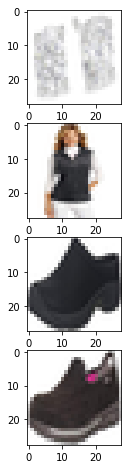

In [95]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B002APTA9K', 'B0085XLLW0', 'B0025ZPQTS', 'B0019MPRJW', 'B000FBKJGO']


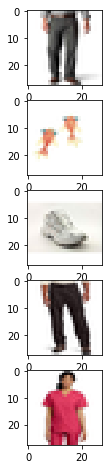

In [96]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_predicted_con.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images) if len(images)<=5 else 5
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Autoencoder model-This section uses the user-item matrix created by item-item neighbours model. We have about 40 training examples of items rated by every user. We use random forest regressor to predict the remaining ratings for each user by training a regression model for each user with training examples of items rated. Each number in vector representation using Autoencoder model is used a feature and the rating is the label. We have the vector representation of all images. Thus the model predicts the rating for unrated items based on its vector represenation

#### Create a copy of user-item matrix predicted by item-item neighbours model

In [58]:
user_item_pivot_con2 = user_item_pivot_con0.copy(deep=True)

#### Read vector representation of each item based on image

In [59]:
feature_df2 = pd.read_csv("item_vector_image3.csv")
feature_df2 = feature_df2[["asin","img_vector"]]

In [60]:
feature_df2.head(5)

,asin,img_vector
0,0000031887,"61.04323959350586,10.855009078979492,67.806251..."
1,0123456479,"69.39546203613281,28.37046241760254,44.9137649..."
2,1608299953,"59.34332275390625,30.055545806884766,47.660144..."
3,1617160377,"59.33428192138672,30.18754005432129,47.7793426..."
4,B00001W0KA,"71.78907775878906,10.117408752441406,79.442283..."


#### Cross-validation and hyper parameter tuning of Random Forest Regressor model using GridSearchCV

In [61]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_pivot_con2.loc[target_user]
items_target = items_target.reset_index()
items_target_na = items_target[items_target[target_user].isna()]
items_target_rated = items_target[~(items_target[target_user].isna())]
features = []
labels = []
for j in items_target_rated['Item_Id']:
    feature = feature_df2.loc[feature_df2['asin'] == j, 'img_vector'].tolist()[0].split(",")
    feature = list(map(float, feature))
    features.append(feature)
    labels.append(user_item_pivot_con2.loc[target_user][j])
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2,4,8,10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(features,labels)
grid_search.best_params_

Fitting 3 folds for each of 576 candidates, totalling 1728 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1728 out of 1728 | elapsed:  3.5min finished
C:\Users\Kiran\AppData\Local\Continuum\anaconda3\envs\env2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 100}

#### Create Random Forest Regressor model for each user and predict unrated items

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
for i in range(0,user_item_pivot_con2.shape[0]):
    print("User:",i)
    target_user = user_item_pivot_con2.index[i]
    items_target = user_item_pivot_con2.loc[target_user]
    items_target = items_target.reset_index()
    items_target_na = items_target[items_target[target_user].isna()]
    items_target_rated = items_target[~(items_target[target_user].isna())]
    model = RandomForestRegressor(n_estimators=100)
    features = []
    labels = []
    for j in items_target_rated['Item_Id']:
        feature = feature_df2.loc[feature_df2['asin'] == j, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        features.append(feature)
        labels.append(user_item_pivot_con2.loc[target_user][j])
    model.fit(features, labels)
        
        
        
    for k in items_target_na['Item_Id']:
        feature = feature_df2.loc[feature_df2['asin'] == k, 'img_vector'].tolist()[0].split(",")
        feature = list(map(float, feature))
        predicted_labels = model.predict([feature])
        user_item_predicted_con2.loc[target_user][k]=predicted_labels[0]
user_item_predicted_con2

User: 0
User: 1
User: 2
User: 3
User: 4
User: 5
User: 6
User: 7
User: 8
User: 9
User: 10
User: 11
User: 12
User: 13
User: 14
User: 15
User: 16
User: 17
User: 18
User: 19
User: 20
User: 21
User: 22
User: 23
User: 24
User: 25
User: 26
User: 27
User: 28
User: 29
User: 30
User: 31
User: 32
User: 33
User: 34
User: 35
User: 36
User: 37
User: 38
User: 39
User: 40
User: 41
User: 42
User: 43
User: 44
User: 45
User: 46
User: 47
User: 48
User: 49
User: 50
User: 51
User: 52
User: 53
User: 54
User: 55
User: 56
User: 57
User: 58
User: 59
User: 60
User: 61
User: 62
User: 63
User: 64
User: 65
User: 66
User: 67
User: 68
User: 69
User: 70
User: 71
User: 72
User: 73
User: 74
User: 75
User: 76
User: 77
User: 78
User: 79
User: 80
User: 81
User: 82
User: 83
User: 84
User: 85
User: 86
User: 87
User: 88
User: 89
User: 90
User: 91
User: 92
User: 93
User: 94
User: 95
User: 96
User: 97
User: 98
User: 99
User: 100
User: 101
User: 102
User: 103
User: 104
User: 105
User: 106
User: 107
User: 108
User: 109
User: 110


User: 831
User: 832
User: 833
User: 834
User: 835
User: 836
User: 837
User: 838
User: 839
User: 840
User: 841
User: 842
User: 843
User: 844
User: 845
User: 846
User: 847
User: 848
User: 849
User: 850
User: 851
User: 852
User: 853
User: 854
User: 855
User: 856
User: 857
User: 858
User: 859
User: 860
User: 861
User: 862
User: 863
User: 864
User: 865
User: 866
User: 867
User: 868
User: 869
User: 870
User: 871
User: 872
User: 873
User: 874
User: 875
User: 876
User: 877
User: 878
User: 879
User: 880
User: 881
User: 882
User: 883
User: 884
User: 885
User: 886
User: 887
User: 888
User: 889
User: 890
User: 891
User: 892
User: 893
User: 894
User: 895
User: 896
User: 897
User: 898
User: 899
User: 900
User: 901
User: 902
User: 903
User: 904
User: 905
User: 906
User: 907
User: 908
User: 909
User: 910
User: 911
User: 912
User: 913
User: 914
User: 915
User: 916
User: 917
User: 918
User: 919
User: 920
User: 921
User: 922
User: 923
User: 924
User: 925
User: 926
User: 927
User: 928
User: 929
User: 930


User: 1592
User: 1593
User: 1594
User: 1595
User: 1596
User: 1597
User: 1598
User: 1599
User: 1600
User: 1601
User: 1602
User: 1603
User: 1604
User: 1605
User: 1606
User: 1607
User: 1608
User: 1609
User: 1610
User: 1611
User: 1612
User: 1613
User: 1614
User: 1615
User: 1616
User: 1617
User: 1618
User: 1619
User: 1620
User: 1621
User: 1622
User: 1623
User: 1624
User: 1625
User: 1626
User: 1627
User: 1628
User: 1629
User: 1630
User: 1631
User: 1632
User: 1633
User: 1634
User: 1635
User: 1636
User: 1637
User: 1638
User: 1639
User: 1640
User: 1641
User: 1642
User: 1643
User: 1644
User: 1645
User: 1646
User: 1647
User: 1648
User: 1649
User: 1650
User: 1651
User: 1652
User: 1653
User: 1654
User: 1655
User: 1656
User: 1657
User: 1658
User: 1659
User: 1660
User: 1661
User: 1662
User: 1663
User: 1664
User: 1665
User: 1666
User: 1667
User: 1668
User: 1669
User: 1670
User: 1671
User: 1672
User: 1673
User: 1674
User: 1675
User: 1676
User: 1677
User: 1678
User: 1679
User: 1680
User: 1681
User: 1682

User: 2337
User: 2338
User: 2339
User: 2340
User: 2341
User: 2342
User: 2343
User: 2344
User: 2345
User: 2346
User: 2347
User: 2348
User: 2349
User: 2350
User: 2351
User: 2352
User: 2353
User: 2354
User: 2355
User: 2356
User: 2357
User: 2358
User: 2359
User: 2360
User: 2361
User: 2362
User: 2363
User: 2364
User: 2365
User: 2366
User: 2367
User: 2368
User: 2369
User: 2370
User: 2371
User: 2372
User: 2373
User: 2374
User: 2375
User: 2376
User: 2377
User: 2378
User: 2379
User: 2380
User: 2381
User: 2382
User: 2383
User: 2384
User: 2385
User: 2386
User: 2387
User: 2388
User: 2389
User: 2390
User: 2391
User: 2392
User: 2393
User: 2394
User: 2395
User: 2396
User: 2397
User: 2398
User: 2399
User: 2400
User: 2401
User: 2402
User: 2403
User: 2404
User: 2405
User: 2406
User: 2407
User: 2408
User: 2409
User: 2410
User: 2411
User: 2412
User: 2413
User: 2414
User: 2415
User: 2416
User: 2417
User: 2418
User: 2419
User: 2420
User: 2421
User: 2422
User: 2423
User: 2424
User: 2425
User: 2426
User: 2427

User: 3082
User: 3083
User: 3084
User: 3085
User: 3086
User: 3087
User: 3088
User: 3089
User: 3090
User: 3091
User: 3092
User: 3093
User: 3094
User: 3095
User: 3096
User: 3097
User: 3098
User: 3099
User: 3100
User: 3101
User: 3102
User: 3103
User: 3104
User: 3105
User: 3106
User: 3107
User: 3108
User: 3109
User: 3110
User: 3111
User: 3112
User: 3113
User: 3114
User: 3115
User: 3116
User: 3117
User: 3118
User: 3119
User: 3120
User: 3121
User: 3122
User: 3123
User: 3124
User: 3125
User: 3126
User: 3127
User: 3128
User: 3129
User: 3130
User: 3131
User: 3132
User: 3133
User: 3134
User: 3135
User: 3136
User: 3137
User: 3138
User: 3139
User: 3140
User: 3141
User: 3142
User: 3143
User: 3144
User: 3145
User: 3146
User: 3147
User: 3148
User: 3149
User: 3150
User: 3151
User: 3152
User: 3153
User: 3154
User: 3155
User: 3156
User: 3157
User: 3158
User: 3159
User: 3160
User: 3161
User: 3162
User: 3163
User: 3164
User: 3165
User: 3166
User: 3167
User: 3168
User: 3169
User: 3170
User: 3171
User: 3172

User: 3827
User: 3828
User: 3829
User: 3830
User: 3831
User: 3832
User: 3833
User: 3834
User: 3835
User: 3836
User: 3837
User: 3838
User: 3839
User: 3840
User: 3841
User: 3842
User: 3843
User: 3844
User: 3845
User: 3846
User: 3847
User: 3848
User: 3849
User: 3850
User: 3851
User: 3852
User: 3853
User: 3854
User: 3855
User: 3856
User: 3857
User: 3858
User: 3859
User: 3860
User: 3861
User: 3862
User: 3863
User: 3864
User: 3865
User: 3866
User: 3867
User: 3868
User: 3869
User: 3870
User: 3871
User: 3872
User: 3873
User: 3874
User: 3875
User: 3876
User: 3877
User: 3878
User: 3879
User: 3880
User: 3881
User: 3882
User: 3883
User: 3884
User: 3885
User: 3886
User: 3887
User: 3888
User: 3889
User: 3890
User: 3891
User: 3892
User: 3893
User: 3894
User: 3895
User: 3896
User: 3897
User: 3898
User: 3899
User: 3900
User: 3901
User: 3902
User: 3903
User: 3904
User: 3905
User: 3906
User: 3907
User: 3908
User: 3909
User: 3910
User: 3911
User: 3912
User: 3913
User: 3914
User: 3915
User: 3916
User: 3917

User: 4572
User: 4573
User: 4574
User: 4575
User: 4576
User: 4577
User: 4578
User: 4579
User: 4580
User: 4581
User: 4582
User: 4583
User: 4584
User: 4585
User: 4586
User: 4587
User: 4588
User: 4589
User: 4590
User: 4591
User: 4592
User: 4593
User: 4594
User: 4595
User: 4596
User: 4597
User: 4598
User: 4599
User: 4600
User: 4601
User: 4602
User: 4603
User: 4604
User: 4605
User: 4606
User: 4607
User: 4608
User: 4609
User: 4610
User: 4611
User: 4612
User: 4613
User: 4614
User: 4615
User: 4616
User: 4617
User: 4618
User: 4619
User: 4620
User: 4621
User: 4622
User: 4623
User: 4624
User: 4625
User: 4626
User: 4627
User: 4628
User: 4629
User: 4630
User: 4631
User: 4632
User: 4633
User: 4634
User: 4635
User: 4636
User: 4637
User: 4638
User: 4639
User: 4640
User: 4641
User: 4642
User: 4643
User: 4644
User: 4645
User: 4646
User: 4647
User: 4648
User: 4649
User: 4650
User: 4651
User: 4652
User: 4653
User: 4654
User: 4655
User: 4656
User: 4657
User: 4658
User: 4659
User: 4660
User: 4661
User: 4662

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A01749481KYG2RR0SF6GR,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
A03236882LUP4ARMDDMXU,4.822214,4.681889,4.827415,4.385091,4.715751,4.806148,4.735208,4.531742,4.635335,4.851861,...,4.812132,4.845574,4.390410,4.896034,4.592681,4.809113,4.596003,4.860736,4.387524,4.737453
A04095881JK7GJRJYSY4N,4.476920,3.923629,4.019367,4.039367,4.057131,4.286920,3.994684,4.394684,3.886288,4.424684,...,4.422026,4.069789,4.121604,4.182026,4.087342,3.981815,3.956498,4.239578,4.296709,3.772236
A0718784TOWF9DX1DOFD,3.845417,3.875624,3.835230,3.384369,3.855727,3.875241,3.855452,3.426895,3.805293,3.775796,...,3.855555,3.806256,3.639963,3.841151,3.795638,3.855923,3.896003,3.846045,3.669566,3.750833
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A102JNFLL0KW7I,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.450000,3.950000,4.180000,4.500000,3.840000,3.670000,3.990000,4.900000,3.930000,4.810000,...,4.280000,4.800000,4.700000,4.750000,4.670000,4.010000,4.240000,4.740000,4.240000,4.320000
A103BJIOJSDJL1,4.140000,4.320000,4.220000,3.780000,4.170000,3.900000,4.030000,3.440000,4.270000,3.400000,...,4.070000,3.600000,3.280000,3.640000,3.630000,4.190000,4.030000,3.620000,3.540000,4.180000
A1057XNJ111NE,1.680000,1.840000,2.000000,2.200000,1.840000,2.560000,2.440000,2.440000,1.640000,2.720000,...,2.400000,2.560000,2.680000,3.120000,3.040000,1.600000,2.600000,3.120000,2.320000,2.040000


#### Evaluation_metrics

In [63]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con2)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A3B9AKWNSKHFLW
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A328HGLW1QWLJV
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: AL5GX3Y4LRHK1
Predicted Ratings: 4.389946833787601
Original Ratings: 5.0


User ID: A13LKNC6P4HFZO
Predicted Ratings: 4.75656137585238
Original Ratings: 3.0


User ID: A3OZR1HAPF767K
Predicted Ratings: 5.0
Original Ratings: 5.0


Root Mean Square Error for Test Data: 0.8315855617724708
Mean Absolute Error for Test Data: 0.4733229084129558


#### Coverage- Print catalog coverage and item coverage

In [64]:
calculate_catalog_coverage(10,user_item_predicted_con2)

0.01

In [65]:
calculate_items_coverage(10,user_item_predicted_con2)

['B00005TQI7', 'B00006XXGO', 'B000072UMJ', 'B000074RL3', 'B0000868O9', 'B000086910', 'B00008ECKG', 'B00008KH9C', 'B00009ZM7Z', 'B0000ANDU4', 'B0000ANECK', 'B0000ANHST', 'B0000AT7N2', 'B0000ATP8L', 'B0000B35D8', 'B0000C321X', 'B0000V9E3S', 'B0000WLSCW', 'B0000ZBSBU', 'B0000ZBSGU', 'B0000ZDSDG', 'B0000ZEPGA', 'B00012O12A', 'B000163G90', 'B00016QOTE', 'B000196UJ0', 'B0001HKKPW', 'B0001MQ60A', 'B0001YR54O', 'B0001YRJSG', 'B0001YS3NG', 'B0001YSBEW', 'B0001ZNZF6', 'B0001ZNZJM', 'B00020BFSE', 'B00022JPNE', 'B00028B4U0', 'B0002FHIM6', 'B0002M7PWW', 'B0002MGM30', 'B0002QTQA2', 'B0002TOS7A', 'B0002TOZ1E', 'B0002TOZ1Y', 'B0002USAW8', 'B0002VN5KY', 'B0002XSXWC', 'B00031XFL2', 'B00062NOFU', 'B0006AAS7E', 'B0006B58LO', 'B0006I3SBY', 'B0006I49Y4', 'B0006IT6JC', 'B0006JALE0', 'B0006LJLMG', 'B0006LMBJ6', 'B0006MY4EU', 'B0006U67WE', 'B00075ZWR4', 'B00075ZXLE', 'B00075ZYRW', 'B00079UM2A', 'B0007CKMA4', 'B0007KPPAI', 'B0007LPM3W', 'B0007MCUTK', 'B0007PQHXW', 'B0007QCOTM', 'B0007QCQGI', 'B0007QMK2S', 'B000

1.0

#### Qualitative Results

#### Display items bought by user

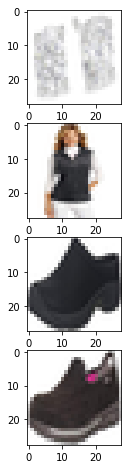

In [66]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B004LZDKJI', 'B004Q7AB4I', 'B007C8PUP8', 'B004RQWP60', 'B003YJBYIQ']


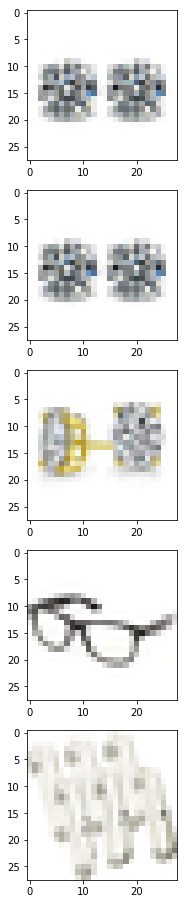

In [97]:
i=20
target_user = user_item_pivot_con2.index[i]
items_target = user_item_predicted_con2.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con2)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Combine doc2vec based and autoencoder based content based recommendation results

In [68]:
user_item_predicted_con_hybrid = (user_item_predicted_con+user_item_predicted_con2)/2

In [69]:
user_item_predicted_con_hybrid

Item_Id,B00005TQI7,B00006XXGO,B000072UMJ,B000074RL3,B0000868O9,B000086910,B00008ECKG,B00008KH9C,B00009ZM7Z,B0000ANDU4,...,B00F2ZX4XS,B00F3IDBZA,B00F7H6FKA,B00F9R8GZA,B00F9RNVM8,B00FEEA4MG,B00FGQB1C4,B00FY7VAQM,B00GI6IASO,B00I0XXR5E
User_Id,,,,,,,,,,,,,,,,,,,,,
A01749481KYG2RR0SF6GR,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
A03236882LUP4ARMDDMXU,4.648246,4.695310,4.822322,4.419830,4.789114,4.785289,4.753717,4.511347,4.715633,4.834507,...,4.780695,4.801939,4.562249,4.786934,4.685547,4.812806,4.602286,4.605212,4.579168,4.740444
A04095881JK7GJRJYSY4N,4.460907,4.051498,4.051604,4.148249,4.106393,4.245591,4.085064,4.361920,3.836393,4.164473,...,4.111815,3.923249,4.025486,4.106709,4.041604,3.993840,4.071920,4.148460,4.016393,3.777722
A0718784TOWF9DX1DOFD,3.737106,3.724813,3.653156,3.531705,3.683323,3.721501,3.746656,3.558162,3.639055,3.664914,...,3.638991,3.606878,3.535055,3.626945,3.663873,3.676648,3.774782,3.754964,3.536174,3.534137
A100WFKYVRPVX7,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A102JNFLL0KW7I,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
A103979529MRJY0U56QI4,4.475000,4.145000,4.400000,4.330000,3.985000,3.930000,4.165000,4.460000,4.165000,4.505000,...,4.405000,4.740000,4.545000,4.505000,4.420000,4.075000,4.245000,4.580000,4.150000,4.205000
A103BJIOJSDJL1,3.895000,3.900000,4.015000,3.760000,3.895000,3.690000,3.770000,3.540000,4.040000,3.475000,...,3.905000,3.795000,3.545000,3.735000,3.675000,3.955000,3.720000,3.790000,3.590000,3.930000
A1057XNJ111NE,2.640000,2.220000,1.820000,2.900000,1.500000,2.420000,1.980000,2.280000,1.740000,2.480000,...,2.040000,2.240000,2.700000,2.540000,2.320000,1.580000,3.000000,3.440000,1.740000,1.780000


#### Evaluation metrics

In [70]:
#print observed and predicted ratings, rmse and mae
user_item_predicted_array = print_ratings(test_df,user_item_predicted_con_hybrid)
test_ratings_array = np.array(test_df.Rating)
rmse = calculate_rmse(user_item_predicted_array,test_ratings_array)
print("Root Mean Square Error for Test Data:", rmse)
mae = calculate_mae(user_item_predicted_array,test_ratings_array)
print("Mean Absolute Error for Test Data:", mae)

User ID: A3B9AKWNSKHFLW
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: A328HGLW1QWLJV
Predicted Ratings: 5.0
Original Ratings: 5.0


User ID: AL5GX3Y4LRHK1
Predicted Ratings: 3.999259789125306
Original Ratings: 5.0


User ID: A13LKNC6P4HFZO
Predicted Ratings: 4.506541068095926
Original Ratings: 3.0


User ID: A3OZR1HAPF767K
Predicted Ratings: 5.0
Original Ratings: 5.0


Root Mean Square Error for Test Data: 0.8088444794299012
Mean Absolute Error for Test Data: 0.501456255794124


#### Coverage

In [71]:
calculate_catalog_coverage(10,user_item_predicted_con_hybrid)

0.01

In [72]:
calculate_items_coverage(10,user_item_predicted_con_hybrid)

['B00005TQI7', 'B00006XXGO', 'B000072UMJ', 'B000074RL3', 'B0000868O9', 'B000086910', 'B00008ECKG', 'B00008KH9C', 'B00009ZM7Z', 'B0000ANDU4', 'B0000ANECK', 'B0000ANHST', 'B0000AT7N2', 'B0000ATP8L', 'B0000B35D8', 'B0000C321X', 'B0000V9E3S', 'B0000WLSCW', 'B0000ZBSBU', 'B0000ZBSGU', 'B0000ZDSDG', 'B0000ZEPGA', 'B00012O12A', 'B000163G90', 'B00016QOTE', 'B000196UJ0', 'B0001HKKPW', 'B0001MQ60A', 'B0001YR54O', 'B0001YRJSG', 'B0001YS3NG', 'B0001YSBEW', 'B0001ZNZF6', 'B0001ZNZJM', 'B00020BFSE', 'B00022JPNE', 'B00028B4U0', 'B0002FHIM6', 'B0002M7PWW', 'B0002MGM30', 'B0002QTQA2', 'B0002TOS7A', 'B0002TOZ1E', 'B0002TOZ1Y', 'B0002USAW8', 'B0002VN5KY', 'B0002XSXWC', 'B00031XFL2', 'B00062NOFU', 'B0006AAS7E', 'B0006B58LO', 'B0006I3SBY', 'B0006I49Y4', 'B0006IT6JC', 'B0006JALE0', 'B0006LJLMG', 'B0006LMBJ6', 'B0006MY4EU', 'B0006U67WE', 'B00075ZWR4', 'B00075ZXLE', 'B00075ZYRW', 'B00079UM2A', 'B0007CKMA4', 'B0007KPPAI', 'B0007LPM3W', 'B0007MCUTK', 'B0007PQHXW', 'B0007QCOTM', 'B0007QCQGI', 'B0007QMK2S', 'B000

1.0

#### Qualitative Results

#### Display items bought by user

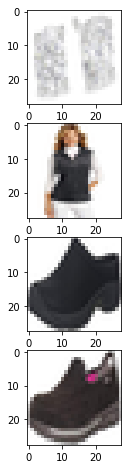

In [89]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_pivot.loc[target_user]
items_target = items_target.reset_index()
items_target_rated = items_target[~(items_target[target_user].isna())]
images = []
for j in items_target_rated['Item_Id']:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

#### Display items recommended for user

['B0085XLLW0', 'B0024FAPTA', 'B003B2XXLM', 'B000SKI752', 'B006R0CDN4']


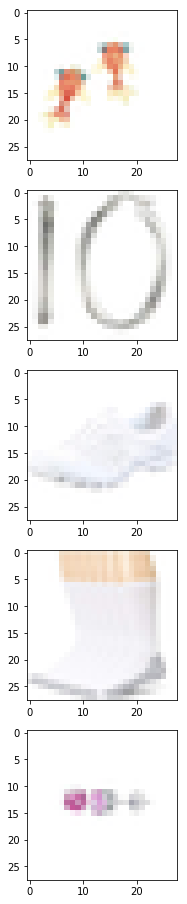

In [90]:
i=20
target_user = user_item_pivot_con.index[i]
items_target = user_item_predicted_con_hybrid.loc[target_user]
items_target = items_target.reset_index()
top_k_items=top_k_items_recommended(5,target_user,user_item_predicted_con_hybrid)
print(top_k_items)
images = []
for j in top_k_items:
    url = df2.loc[df2['asin'] == j, 'imUrl'].iloc[0]
    fd = urllib.urlopen(url)
    image_file = io.BytesIO(fd.read())
    im = Image.open(image_file)
    size = 28, 28
    img = im.resize(size, Image.ANTIALIAS)
    img = img.convert(mode="RGB")
    images.append(img)
fig=plt.figure(figsize=(16, 16))
columns = 1
rows = len(images)
for i in range(0, columns*rows):
    img = images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()